# Food vision mini
 - 101 classes
    trained on 10% of the data
    Complete test data

In [1]:
import tensorflow as tf
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import os

In [2]:
model_name = "101_classes_10_percent"

#### Model Checkpoint Callback

In [3]:
checkpoint_path = f"model_logs/checkpoints/{model_name}"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                               save_weights_only=True,
                                                               monitor="val_accuracy",
                                                               save_best_only=True)

### Tensorboard Callback

In [4]:
def create_tensorboard_callback(experiment_name, model_name):
    log_dir = os.path.join("model_logs", str(experiment_name),
                           str(model_name), dt.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f"[create_tensorboard_callback] The log dir for tensorboard is : {log_dir}")
    return tensorboard_callback
tensorboard_callback = create_tensorboard_callback("food_vision", model_name)

[create_tensorboard_callback] The log dir for tensorboard is : model_logs/food_vision/101_classes_10_percent/20220122-142450


### Prepare Train and Test data

In [5]:
DATASET_SOURCE = "/home/arun/learn/tensorflow_certification/datasets/food_101/complete_10/"
train_dir = os.path.join(DATASET_SOURCE, "train")
test_dir = os.path.join(DATASET_SOURCE, "test")

train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 batch_size=32,
                                                                 image_size=(224, 224),
                                                                 label_mode="categorical")
valid_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                 batch_size=32,
                                                                 image_size=(224,224),
                                                                 label_mode="categorical")

Found 7575 files belonging to 101 classes.


2022-01-22 14:24:50.723763: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 14:24:50.730476: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 14:24:50.731579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-22 14:24:50.732488: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 25250 files belonging to 101 classes.


Model: "101_classes_10_percent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 12

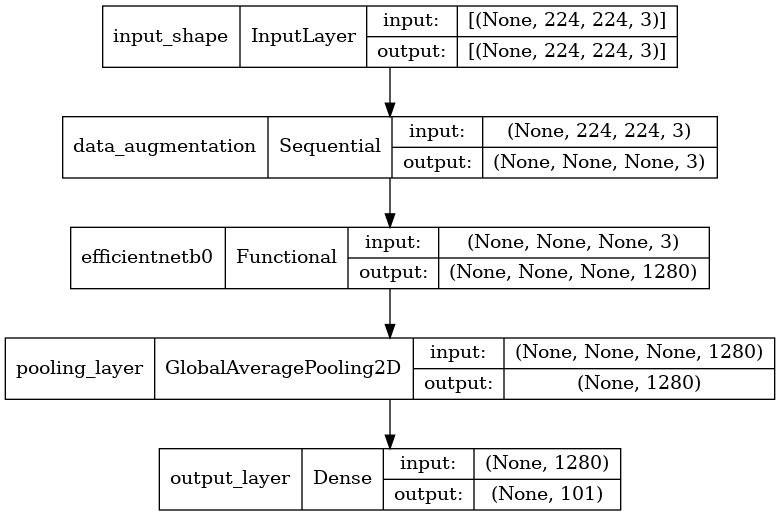

In [16]:
# Building the base model to beat the base accuracy of 50% mentioned in the paper
tf.random.set_seed(273)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.layers.Input(shape=(224,224,3), name="input_shape")
data_augmentation = tf.keras.Sequential(layers=[
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomZoom(0.2),
], name="data_augmentation")
preprocessing_layer = data_augmentation(inputs)

layer_2 = base_model(preprocessing_layer, training=False)
# feature extractor, pooling layer, avg pool the  outputs
pooling_layer = tf.keras.layers.GlobalAveragePooling2D(name="pooling_layer")(layer_2)
outputs = tf.keras.layers.Dense(units=101, activation="softmax", name="output_layer")(pooling_layer)

model_0 = tf.keras.Model(inputs=inputs, outputs=outputs, name=model_name)
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_0.summary()
tf.keras.utils.plot_model(model=model_0, show_shapes=True)

In [17]:
history_model_0 = model_0.fit(train_data, validation_data=valid_data,
                              epochs=5,
                              steps_per_epoch=len(train_data),
                              validation_steps=int(0.15* len(valid_data)),
                              callbacks=[model_checkpoint_callback, tensorboard_callback])

/home/arun/learn/tensorflow_certification/venv/lib/python3.8/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


Epoch 1/5
237/237 [==============================] - 70s 269ms/step - loss: 3.4721 - accuracy: 0.2482 - val_loss: 2.4446 - val_accuracy: 0.4529
Epoch 2/5
237/237 [==============================] - 62s 262ms/step - loss: 2.3507 - accuracy: 0.4665 - val_loss: 2.0223 - val_accuracy: 0.5090
Epoch 3/5
237/237 [==============================] - 63s 266ms/step - loss: 1.9947 - accuracy: 0.5263 - val_loss: 1.8615 - val_accuracy: 0.5336
Epoch 4/5
237/237 [==============================] - 61s 256ms/step - loss: 1.7836 - accuracy: 0.5671 - val_loss: 1.7869 - val_accuracy: 0.5477
Epoch 5/5
237/237 [==============================] - 60s 252ms/step - loss: 1.6238 - accuracy: 0.6062 - val_loss: 1.7306 - val_accuracy: 0.5546


In [18]:
for layer in base_model.layers:
    print(layer.name, layer.trainable)
    
base_model.trainable = True
for layer in base_model.layers[:-5]:
    layer.trainable = False

for layer in base_model.layers:
    print(layer.name, layer.trainable)

input_3 False
rescaling_2 False
normalization_2 False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False
block2a_dwconv_pad False
block2a_dwconv False
block2a_bn False
block2a_activation False
block2a_se_squeeze False
block2a_se_reshape False
block2a_se_reduce False
block2a_se_expand False
block2a_se_excite False
block2a_project_conv False
block2a_project_bn False
block2b_expand_conv False
block2b_expand_bn False
block2b_expand_activation False
block2b_dwconv False
block2b_bn False
block2b_activation False
block2b_se_squeeze False
block2b_se_reshape False
block2b_se_reduce False
block2b_se_expand False
block2b_se_excite False
block2b_project_conv False

In [21]:
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])
model_0.summary()

Model: "101_classes_10_percent"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 91

In [22]:
history_model_0_fine_tuning = model_0.fit(train_data,
                                          validation_data=valid_data,
                                          epochs=10,
                                          initial_epoch=history_model_0.epoch[-1],
                                          steps_per_epoch=len(train_data),
                                          validation_steps=int(0.25*len(valid_data)))

Epoch 5/10
237/237 [==============================] - 80s 312ms/step - loss: 1.2038 - accuracy: 0.6841 - val_loss: 1.6118 - val_accuracy: 0.5746
Epoch 6/10
237/237 [==============================] - 69s 292ms/step - loss: 1.0715 - accuracy: 0.7152 - val_loss: 1.6106 - val_accuracy: 0.5761
Epoch 7/10
237/237 [==============================] - 63s 267ms/step - loss: 0.9783 - accuracy: 0.7451 - val_loss: 1.6105 - val_accuracy: 0.5774
Epoch 8/10
237/237 [==============================] - 62s 261ms/step - loss: 0.9238 - accuracy: 0.7576 - val_loss: 1.6092 - val_accuracy: 0.5761
Epoch 9/10
237/237 [==============================] - 69s 292ms/step - loss: 0.8696 - accuracy: 0.7654 - val_loss: 1.6037 - val_accuracy: 0.5855
Epoch 10/10
237/237 [==============================] - 67s 283ms/step - loss: 0.8177 - accuracy: 0.7894 - val_loss: 1.6026 - val_accuracy: 0.5860


In [23]:
model_0.evaluate(valid_data)

790/790 [==============================] - 96s 121ms/step - loss: 1.5998 - accuracy: 0.5843


[1.5997933149337769, 0.5842772126197815]